In [554]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from typing import List, Tuple

In [555]:
# Helper functions
def get_characters_from_filename(filename: str) -> Tuple[List[str], int]:
    characters = filename.split('/')[-1].split('-0.png')[0]
    return characters, len(characters)

def get_rgb_image(image: np.ndarray) -> np.ndarray:
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def get_gray_image(image: np.ndarray) -> np.ndarray:
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def load_image(image_path: str) -> np.ndarray:
    return cv2.imread(image_path)

def show_image(image: np.ndarray) -> None:
    # Detect if image is grayscale or color
    plt.figure(figsize=(3,2))
    if len(image.shape) == 2:
        # Grayscale image
        plt.imshow(image, cmap='gray')
    else:
        # Color image - convert from BGR to RGB for matplotlib
        plt.imshow(image)
    plt.axis('off')
    plt.show()


In [556]:
def clean_image(image: np.ndarray) -> np.ndarray:
    # Clean image from black lines and noise
    gray = get_gray_image(image)
    black_mask = gray < 1  # Adjust threshold
    black_mask = black_mask.astype(np.uint8) * 255
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    cleaned_mask = cv2.morphologyEx(black_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    inverse_mask = cv2.bitwise_not(cleaned_mask)
    img_rgb_clean = image.copy()
    img_rgb_clean[inverse_mask == 0] = [255, 255, 255]
    return img_rgb_clean

In [ ]:
def dilate_image(image: np.ndarray) -> np.ndarray:
    """
    Dilate the image to strengthen character pixels.
    """
    kernel = np.ones((3,3), np.uint8)
    invert_image = cv2.bitwise_not(image)
    invert_image = cv2.dilate(invert_image, kernel, iterations=2)
    return cv2.bitwise_not(invert_image)

def get_k_means_clusters(image: np.ndarray, num_characters: int) -> List[np.ndarray]:
    """
    Apply k-means clustering to segment characters by color.
    
    Args:
        image: RGB image (h, w, 3)
        num_characters: Number of characters to segment
    
    Returns:
        List of binary masks, one per character cluster
    """
    # Remove white background pixels
    mask_nonwhite = np.any(image < 240, axis=-1)
    pixels = image[mask_nonwhite]
    pixels = np.float32(pixels)

    # Apply k-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, num_characters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Create masks per cluster and remove noise
    h, w, _ = image.shape
    cluster_masks = []
    label_image = np.full((h, w), -1, dtype=np.int32)
    label_image[mask_nonwhite] = labels.flatten()

    # Removing noise
    min_area = 40   # Minimum area for a "blob" to be kept as a character, adjust as needed

    for i in range(num_characters):
        cluster_mask = (label_image == i).astype(np.uint8) * 255

        # Remove small connected components ("noise dots"): keep only blobs >= min_area
        num_labels, comp_labels, stats, centroids = cv2.connectedComponentsWithStats(cluster_mask, connectivity=8)
        clean_mask = np.zeros_like(cluster_mask)
        for j in range(1, num_labels):  # skip background
            area = stats[j, cv2.CC_STAT_AREA]
            if area >= min_area:
                clean_mask[comp_labels == j] = 255

        # Optional: Morphological closing can help connect fragmented parts of actual characters a bit, but not too aggressive
        kernel_close = np.ones((3, 3), np.uint8)  # for closing isolated dots
        clean_mask = cv2.erode(clean_mask, kernel_close, iterations=1)
        clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel_close, iterations=1)

        cluster_masks.append(clean_mask)
    
    return cluster_masks

def get_k_means_clusters_lab(image: np.ndarray, num_characters: int) -> List[np.ndarray]:
    """
    Apply k-means clustering to segment characters by color in LAB color space.
    LAB color space is perceptually uniform, which can provide better color-based segmentation.
    
    Args:
        image: RGB image (h, w, 3)
        num_characters: Number of characters to segment
    
    Returns:
        List of binary masks, one per character cluster
    """
    # Convert RGB to LAB color space for perceptually uniform clustering
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    # Remove white background pixels (check in RGB space)
    mask_nonwhite = np.any(image < 240, axis=-1)
    pixels_lab = image_lab[mask_nonwhite]
    pixels_lab = np.float32(pixels_lab)

    # Apply k-means clustering in LAB space
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels_lab, num_characters, None, criteria, 10, cv2.KMEANS_PP_CENTERS)

    # Create masks per cluster and remove noise
    h, w, _ = image.shape
    cluster_masks = []
    label_image = np.full((h, w), -1, dtype=np.int32)
    label_image[mask_nonwhite] = labels.flatten()

    # Removing noise
    min_area = 40   # Minimum area for a "blob" to be kept as a character, adjust as needed
    kernel_close = np.ones((3, 3), np.uint8)  # for closing isolated dots

    for i in range(num_characters):
        cluster_mask = (label_image == i).astype(np.uint8) * 255

        # Remove small connected components ("noise dots"): keep only blobs >= min_area
        num_labels, comp_labels, stats, centroids = cv2.connectedComponentsWithStats(cluster_mask, connectivity=8)
        clean_mask = np.zeros_like(cluster_mask)
        for j in range(1, num_labels):  # skip background
            area = stats[j, cv2.CC_STAT_AREA]
            if area >= min_area:
                clean_mask[comp_labels == j] = 255

        # Optional: Morphological closing can help connect fragmented parts of actual characters a bit, but not too aggressive
        clean_mask = cv2.erode(clean_mask, kernel_close, iterations=1)
        clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel_close, iterations=1)

        cluster_masks.append(clean_mask)
    
    return cluster_masks

def reconstruct_from_clusters(cluster_masks: List[np.ndarray]) -> np.ndarray:
    h, w = cluster_masks[0].shape
    reconstructed = np.zeros((h, w), dtype=np.uint8)
    
    for mask in cluster_masks:
        reconstructed = cv2.bitwise_or(mask, reconstructed)
    
    return reconstructed

def get_contours_from_masks(cluster_masks: List[np.ndarray]) -> List[np.ndarray]:
    contours = []
    for mask in cluster_masks:
        mask_contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours.extend(mask_contours)
    
    return contours

def get_bounding_boxes(contours: List[np.ndarray]) -> List[Tuple[int, int, int, int]]:
    return [cv2.boundingRect(contour) for contour in contours]


In [1]:
def _uf_find(x, parent):
    if parent[x] != x:
        parent[x] = _uf_find(parent[x], parent)
    return parent[x]

def _uf_union(x, y, parent):
    px, py = _uf_find(x, parent), _uf_find(y, parent)
    if px != py:
        parent[px] = py

def _merge_groups(bounding_boxes, groups):
    merged_boxes = []
    for group in groups.values():
        # Find bounding box that contains all boxes in the group
        min_x = min(x for x, y, w, h in group)
        min_y = min(y for x, y, w, h in group)
        max_x = max(x + w for x, y, w, h in group)
        max_y = max(y + h for x, y, w, h in group)
        merged_boxes.append([min_x, min_y, max_x - min_x, max_y - min_y])
    # Sort by x-coordinate
    merged_boxes.sort(key=lambda box: box[0])
    return merged_boxes

def merge_boxes_small_nearby(bounding_boxes, width_threshold=0.5, height_threshold=0.5, distance_threshold=30):
    """
    Merge small bounding boxes with nearby larger boxes.
    This is useful for merging character fragments (dots, diacritics, noise) with main characters.
    A box is considered "small" if its width OR height is below the threshold.
    Returns:
        List of merged bounding boxes
    """
    if not bounding_boxes or len(bounding_boxes) <= 1:
        return bounding_boxes

    widths = [w for x, y, w, h in bounding_boxes]
    heights = [h for x, y, w, h in bounding_boxes]
    median_width = np.median(widths)
    median_height = np.median(heights)

    small_width_threshold = median_width * width_threshold
    small_height_threshold = median_height * height_threshold

    # Create list with indices and dimensions
    boxes_with_info = []
    for idx, box in enumerate(bounding_boxes):
        x, y, w, h = box
        center_x = x + w / 2
        center_y = y + h / 2
        is_small = (w < small_width_threshold) and (h < small_height_threshold)
        boxes_with_info.append({
            'idx': idx,
            'box': box,
            'width': w,
            'height': h,
            'center': (center_x, center_y),
            'is_small': is_small,
            'merged_with': None
        })

    n = len(bounding_boxes)
    parent = list(range(n))

    def distance(center1, center2):
        return np.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)

    # For each small box, find the nearest larger box
    for i, box_i in enumerate(boxes_with_info):
        if not box_i['is_small']:
            continue

        nearest_idx = None
        nearest_dist = float('inf')
        for j, box_j in enumerate(boxes_with_info):
            if i == j or box_j['is_small']:
                continue
            dist = distance(box_i['center'], box_j['center'])
            if dist < nearest_dist:
                nearest_dist = dist
                nearest_idx = j
        if nearest_idx is not None and nearest_dist <= distance_threshold:
            _uf_union(i, nearest_idx, parent)
    # Group boxes by their root parent
    groups = {}
    for i in range(n):
        root = _uf_find(i, parent)
        if root not in groups:
            groups[root] = []
        groups[root].append(bounding_boxes[i])

    return _merge_groups(bounding_boxes, groups)

def merge_boxes_overlapping_x(bounding_boxes, overlap_threshold=0.8):
    """
    Merge bounding boxes if their x-ranges overlap by more than overlap_threshold.
    Returns:
        List of merged bounding boxes
    """
    if not bounding_boxes:
        return []

    n = len(bounding_boxes)
    parent = list(range(n))

    # Check all pairs for overlap
    for i in range(n):
        for j in range(i + 1, n):
            x1, y1, w1, h1 = bounding_boxes[i]
            x2, y2, w2, h2 = bounding_boxes[j]
            x1_start, x1_end = x1, x1 + w1
            x2_start, x2_end = x2, x2 + w2

            overlap_start = max(x1_start, x2_start)
            overlap_end = min(x1_end, x2_end)
            overlap_width = max(0, overlap_end - overlap_start)

            min_width = min(w1, w2)
            overlap_pct = overlap_width / min_width if min_width > 0 else 0

            if overlap_pct > overlap_threshold:
                _uf_union(i, j, parent)

    # Group boxes by their root parent
    groups = {}
    for i in range(n):
        root = _uf_find(i, parent)
        if root not in groups:
            groups[root] = []
        groups[root].append(bounding_boxes[i])

    return _merge_groups(bounding_boxes, groups)

In [559]:
def get_color_hist_in_bounding_box(bounding_box, image: np.ndarray):
    x, y, w, h = bounding_box
    roi = image[y:y+h, x:x+w]
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_RGB2HSV)
    hue = hsv_roi[..., 0].flatten()
    sat = hsv_roi[..., 1].flatten()
    val = hsv_roi[..., 2].flatten()
    not_white_mask = ~((sat < 20) & (val > 200))
    hue_filtered = hue[not_white_mask]
    sat_filtered = sat[not_white_mask]

    if len(hue_filtered) == 0 or len(sat_filtered) == 0:
        return [], [], [], []
    
    # Dominant hue
    hue_hist, hue_bin_edges = np.histogram(hue_filtered, bins=36, range=(0, 180))
    # Dominant saturation
    sat_hist, sat_bin_edges = np.histogram(sat_filtered, bins=16, range=(0, 256))

    return hue_hist, sat_hist, hue_bin_edges, sat_bin_edges

def get_dominant_color_in_bounding_box(bounding_box, image: np.ndarray):
    hue_hist, sat_hist, hue_bin_edges, sat_bin_edges = get_color_hist_in_bounding_box(bounding_box, image)

    if len(hue_hist) == 0 or len(sat_hist) == 0:
        return 0, 0
    
    dominant_hue_idx = np.argmax(hue_hist)
    dominant_hue = (hue_bin_edges[dominant_hue_idx] + hue_bin_edges[dominant_hue_idx + 1]) / 2
    dominant_sat_idx = np.argmax(sat_hist)
    dominant_sat = (sat_bin_edges[dominant_sat_idx] + sat_bin_edges[dominant_sat_idx + 1]) / 2
    return dominant_hue, dominant_sat


In [560]:
def merge_adjacent_boxes_by_dominant_color(
    bounding_boxes, image: np.ndarray, hue_tol=5, sat_tol=5
):
    """
    Merge adjacent bounding boxes if their dominant hue is the same (within hue_tol)
    AND their dominant saturation is the same (within sat_tol).
    Returns new list of merged bounding boxes.
    """
    if not bounding_boxes:
        return []

    # Compute dominant hue and dominant saturation for each bounding box
    dominant_hues = []
    dominant_sats = []
    for box in bounding_boxes:
        dominant_hue, dominant_sat = get_dominant_color_in_bounding_box(box, image)
        dominant_hues.append(dominant_hue)
        dominant_sats.append(dominant_sat)

    merged_boxes = []
    current_box = list(bounding_boxes[0])
    current_hue = dominant_hues[0]
    current_sat = dominant_sats[0]

    for i in range(1, len(bounding_boxes)):
        next_box = bounding_boxes[i]
        next_hue = dominant_hues[i]
        next_sat = dominant_sats[i]

        # Check if adjacent (touching or 1-pixel apart in x-direction)
        curr_x, curr_y, curr_w, curr_h = current_box
        next_x, next_y, next_w, next_h = next_box

        same_hue = abs(current_hue - next_hue) <= hue_tol
        same_sat = abs(current_sat - next_sat) <= sat_tol
        same_color = same_hue and same_sat

        if same_color:
            # Merge boxes
            new_x = min(curr_x, next_x)
            new_y = min(curr_y, next_y)
            new_w = max(curr_x + curr_w, next_x + next_w) - new_x
            new_h = max(curr_y + curr_h, next_y + next_h) - new_y
            current_box = [new_x, new_y, new_w, new_h]
            # keep current_hue/current_sat unchanged for next check
        else:
            merged_boxes.append(tuple(current_box))
            current_box = list(next_box)
            current_hue = next_hue
            current_sat = next_sat

    merged_boxes.append(tuple(current_box))
    return merged_boxes


In [561]:
def split_boxes_by_dominant_color(bounding_boxes, image: np.ndarray):
    pass

In [ ]:
def dilate_and_reconstruct(image: np.ndarray, clusters: List[np.ndarray], bounding_boxes: List[Tuple[int, int, int, int]]) -> List[Tuple[int, int, int, int]]:
    low_pixel_density_threshold = 0.4
    dilation_iterations = 2

    kernel = np.ones((3, 3), np.uint8)

    needs_dilation = False

    for x, y, w, h in bounding_boxes:
        roi = image[y:y+h, x:x+w]
        pixel_count = np.count_nonzero(roi)
        box_area = w * h
        pixel_density = pixel_count / box_area if box_area > 0 else 0
        
        if pixel_density < low_pixel_density_threshold:
            needs_dilation = True
            break

    dilated_cluster_masks = []
    if needs_dilation:
        for mask in clusters:
            dilated_mask = cv2.dilate(mask, kernel, iterations=dilation_iterations)
            dilated_cluster_masks.append(dilated_mask)
        
        contours = get_contours_from_masks(dilated_cluster_masks)
        bounding_boxes = get_bounding_boxes(contours)
        reconstructed = reconstruct_from_clusters(dilated_cluster_masks)

    return bounding_boxes, dilated_cluster_masks if needs_dilation else clusters, reconstructed if needs_dilation else image
        

In [ ]:
def show_bounding_boxes(bounding_boxes, image):
    for x, y, w, h in bounding_boxes:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    show_image(image)

In [ ]:
def process_image(filepath: str, show_images=False):
    # 1. Load image
    num_characters = get_characters_from_filename(filepath)[1]
    image = load_image(filepath)
    image_rgb = get_rgb_image(image)
    if show_images:
        show_image(image_rgb)

    # 2. Clean image (black lines and noise)
    image_clean = clean_image(image_rgb)
    if show_images:
        show_image(image_clean)

    # 3. Dilate image
    image_dilated = dilate_image(image_clean)
    if show_images:
        show_image(image_dilated)

    # 4. Get k-means clusters
    clusters = get_k_means_clusters_lab(image_dilated, num_characters)

    # Show clusters masks
    if show_images:
        for i, cluster in enumerate(clusters):
            plt.axis('off')
            plt.imshow(cluster, cmap='gray')
            plt.show()

    # 5. Get contours from clusters
    contours = get_contours_from_masks(clusters)

    # 6. Reconstruct image from clusters    
    reconstructed = reconstruct_from_clusters(clusters)
    # show_image(reconstructed)

    # 6. Get bounding boxes from countours of cluster masks
    bounding_boxes = get_bounding_boxes(contours)

    # =============================
    # Bounding boxes post-processing
    # =============================
    iteration = 0
    while len(bounding_boxes) != num_characters and iteration < num_characters:
        # 7. Merge small boxes with nearby larger boxes
        if len(bounding_boxes) > num_characters: # Too many bounding boxes
            bounding_boxes, _, reconstructed = dilate_and_reconstruct(reconstructed, clusters, bounding_boxes)

            bounding_boxes = merge_boxes_small_nearby(bounding_boxes, width_threshold=0.5, height_threshold=0.5, distance_threshold=30)

            bounding_boxes = merge_boxes_overlapping_x(bounding_boxes, overlap_threshold=0.7)

        elif len(bounding_boxes) < num_characters:
            bounding_boxes = merge_adjacent_boxes_by_dominant_color(bounding_boxes, image)

        iteration += 1

    # 9. Visualize results
    reconstructed_color = cv2.cvtColor(reconstructed, cv2.COLOR_GRAY2RGB)
    for x, y, w, h in bounding_boxes:
        cv2.rectangle(reconstructed_color, (x, y), (x + w, y + h), (0, 255, 0), 2)

    if show_images:
        plt.subplot(133)
        plt.imshow(reconstructed_color)
        plt.title(f'Reconstructed with {len(bounding_boxes)} Bounding Boxes')
        plt.axis('off')
        plt.show()

    # print(f"Bounding boxes: {len(bounding_boxes)}")
    # print(f"Number of characters: {num_characters}")
    if len(bounding_boxes) == num_characters:
        return "correct"
    elif len(bounding_boxes) < num_characters:
        return "smaller"
    else:
        return "larger"


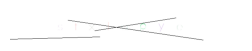

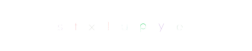

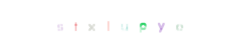

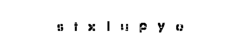

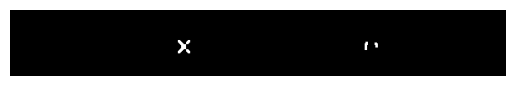

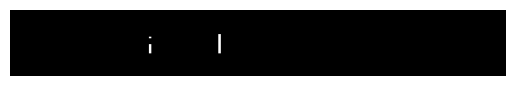

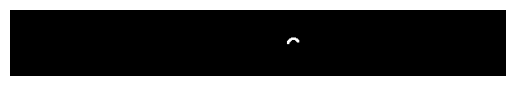

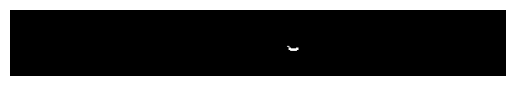

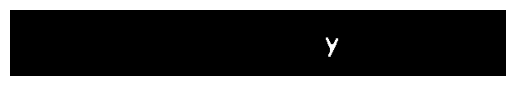

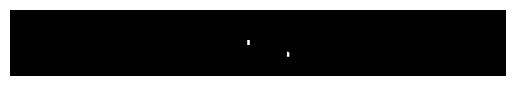

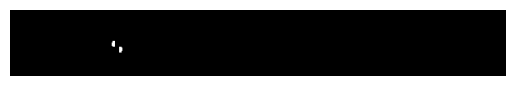

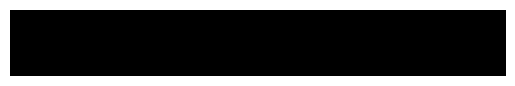

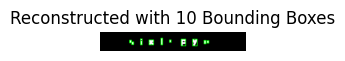

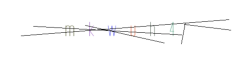

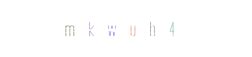

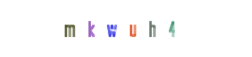

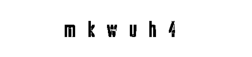

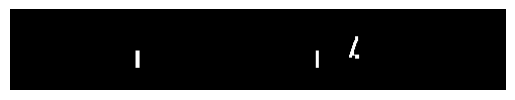

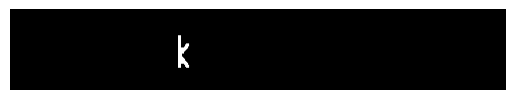

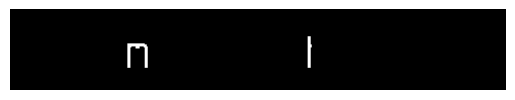

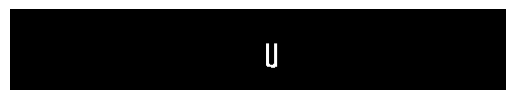

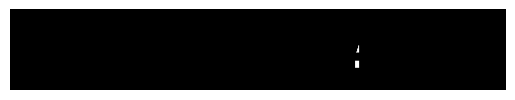

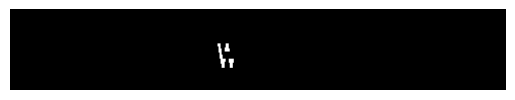

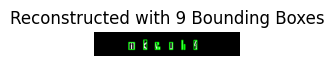

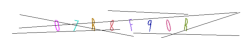

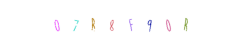

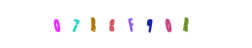

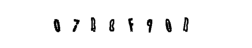

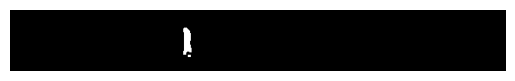

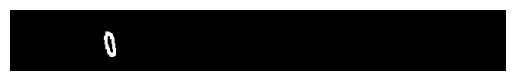

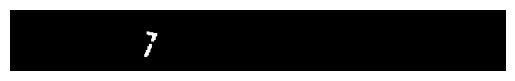

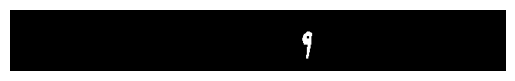

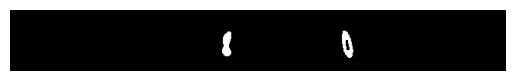

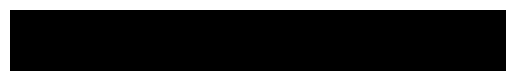

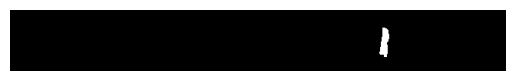

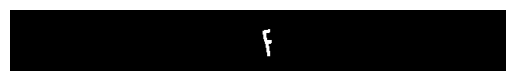

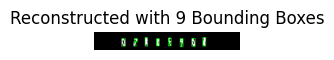

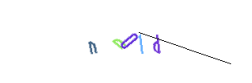

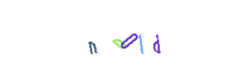

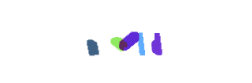

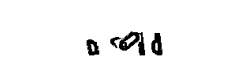

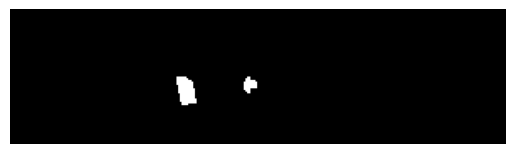

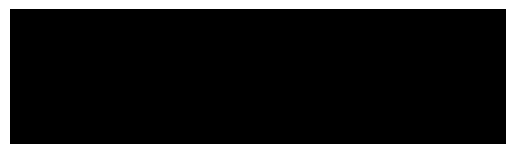

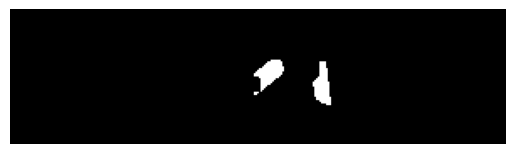

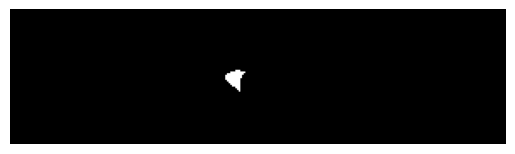

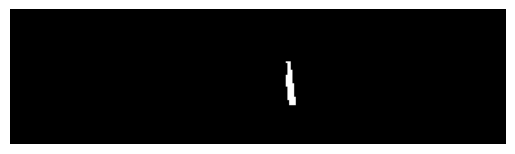

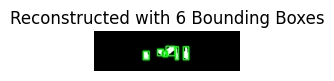

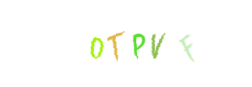

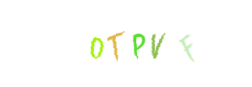

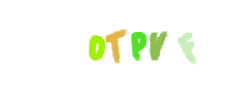

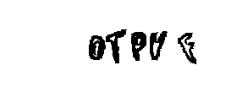

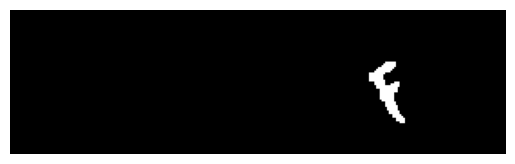

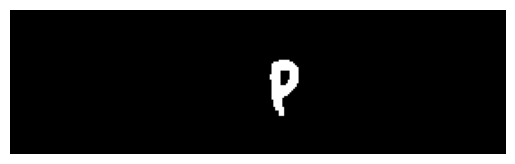

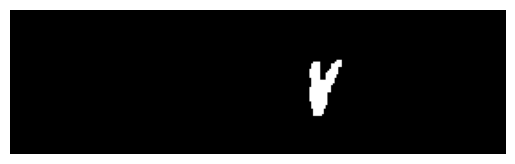

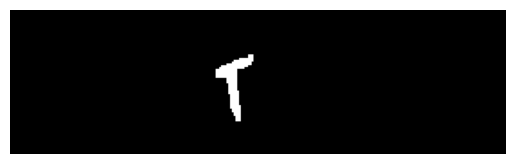

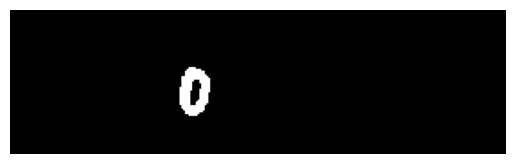

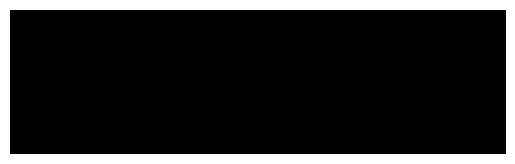

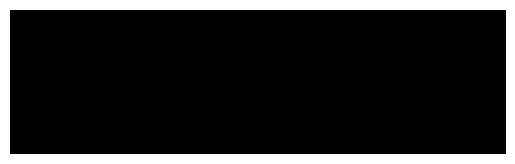

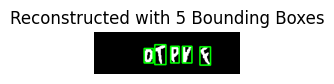

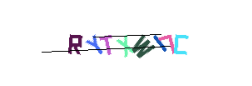

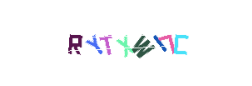

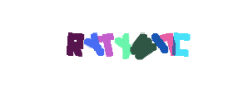

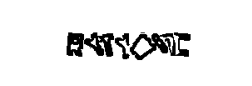

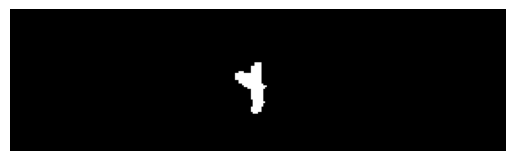

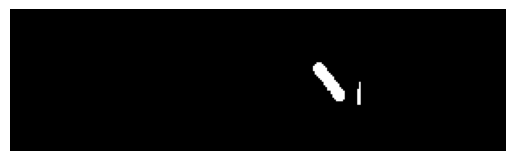

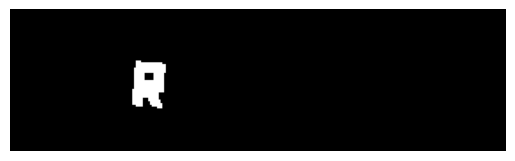

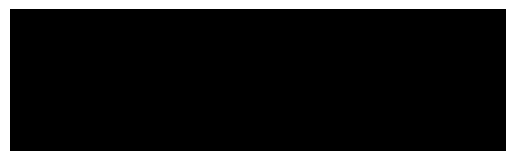

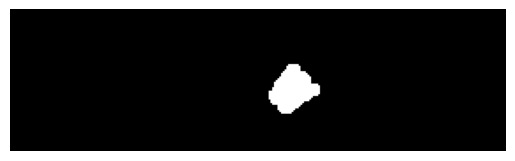

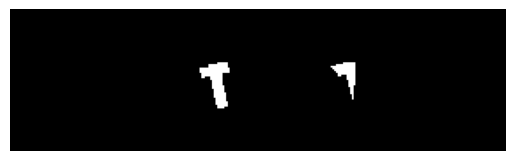

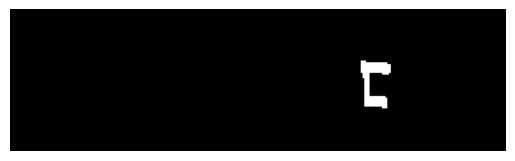

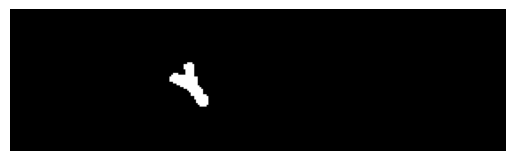

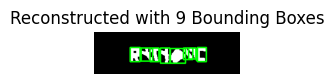

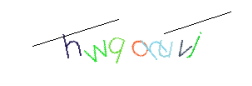

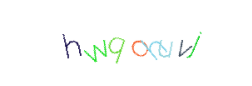

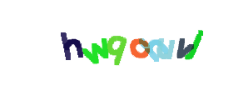

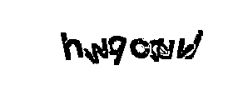

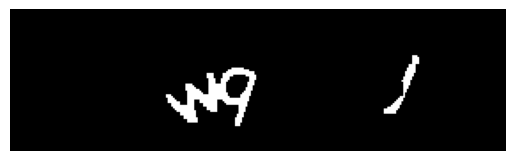

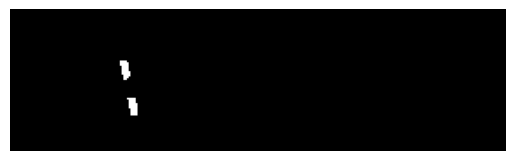

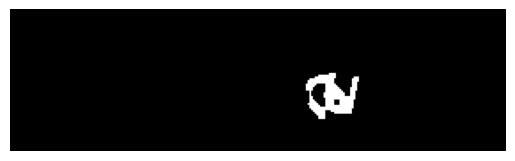

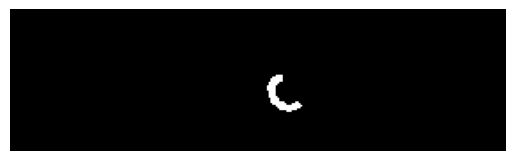

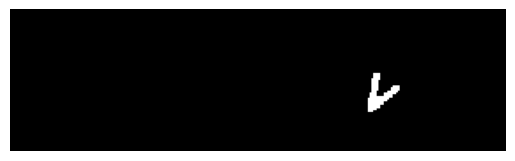

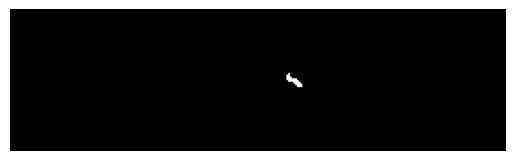

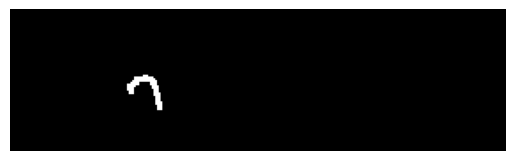

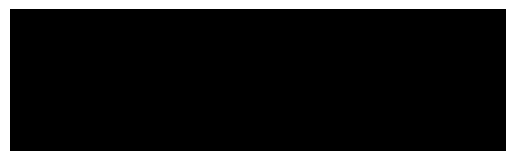

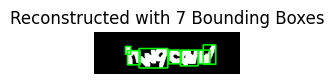

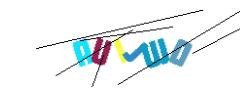

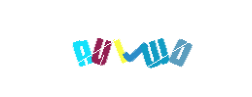

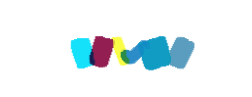

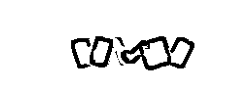

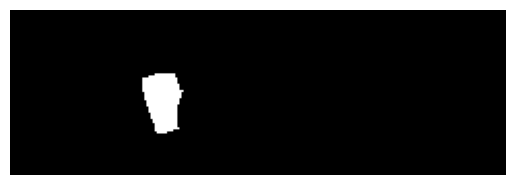

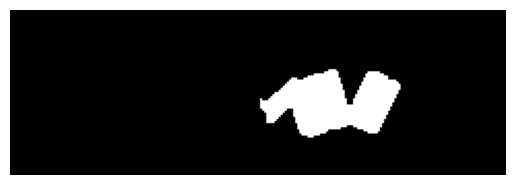

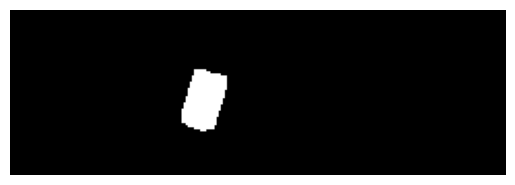

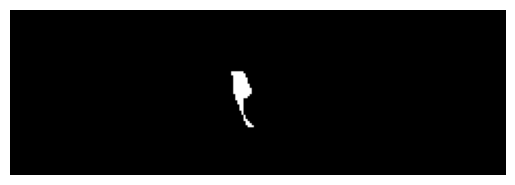

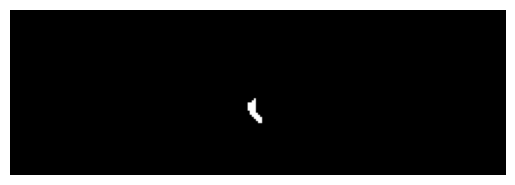

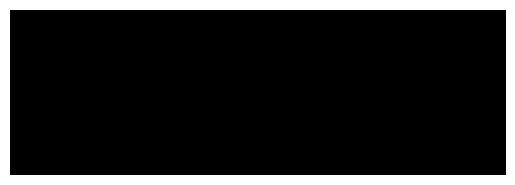

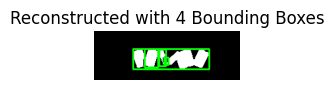

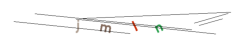

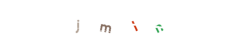

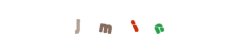

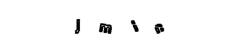

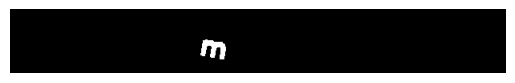

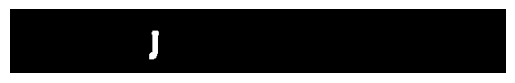

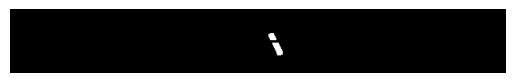

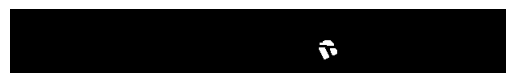

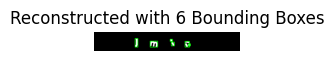

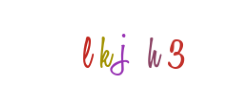

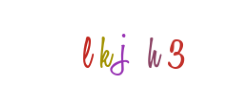

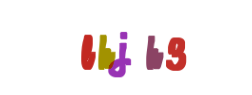

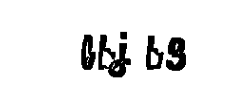

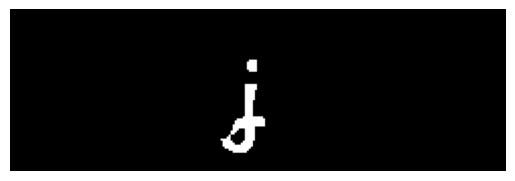

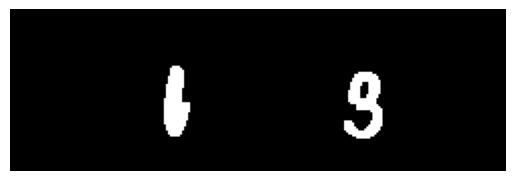

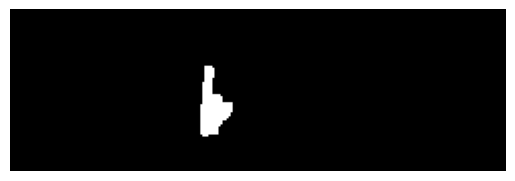

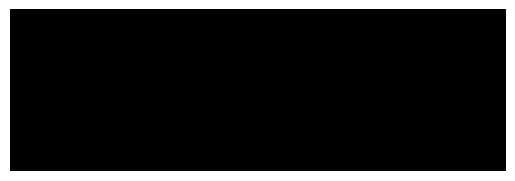

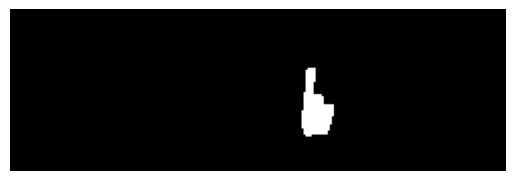

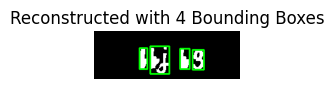

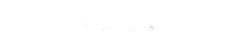

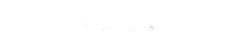

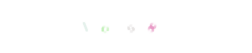

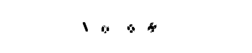

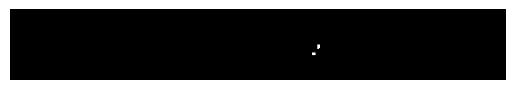

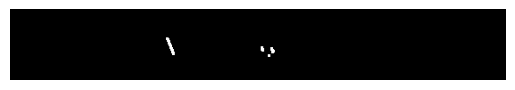

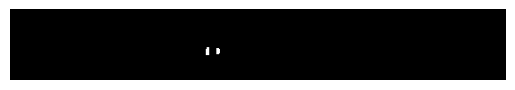

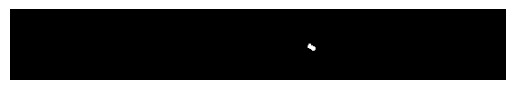

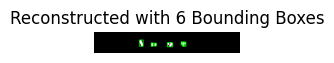

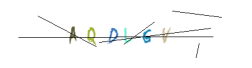

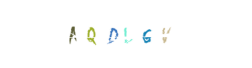

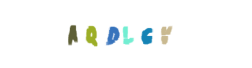

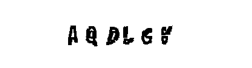

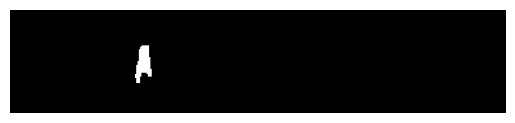

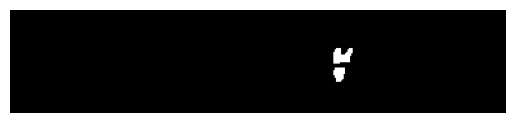

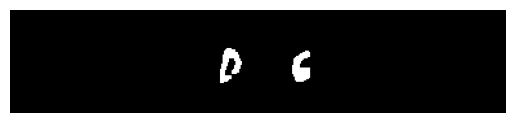

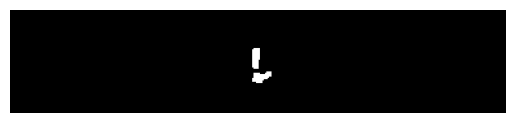

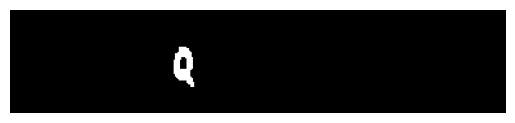

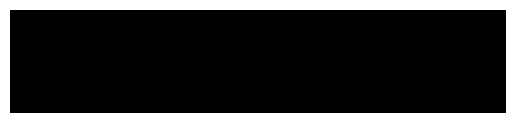

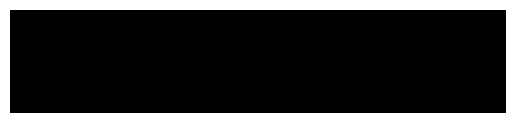

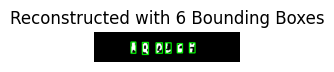

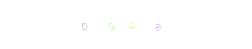

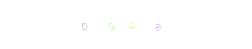

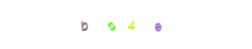

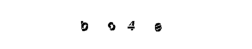

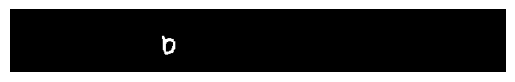

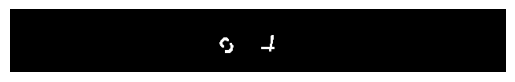

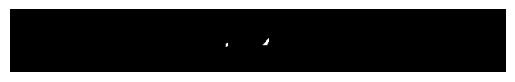

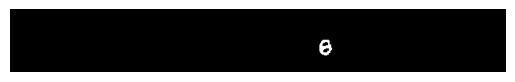

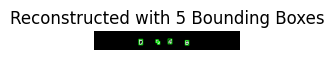

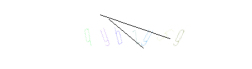

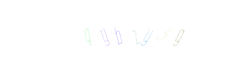

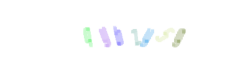

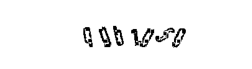

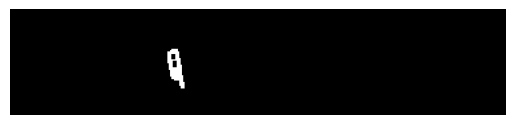

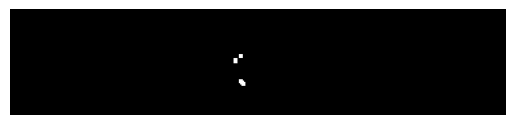

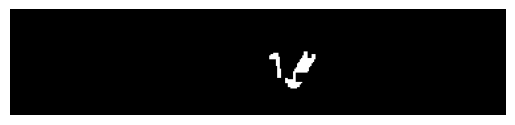

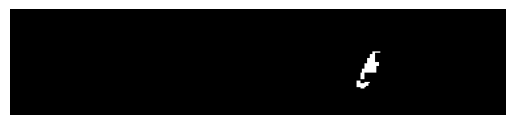

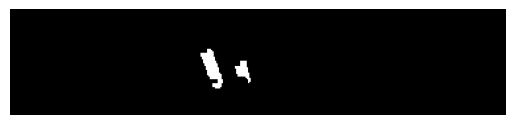

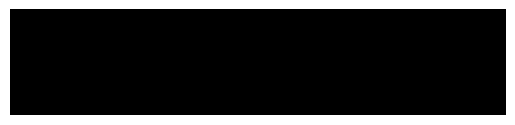

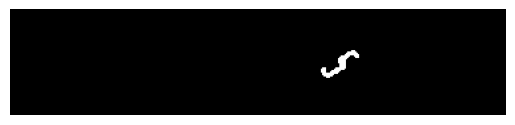

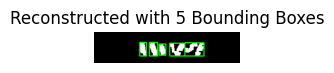

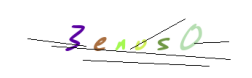

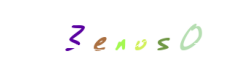

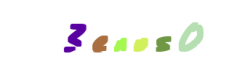

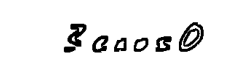

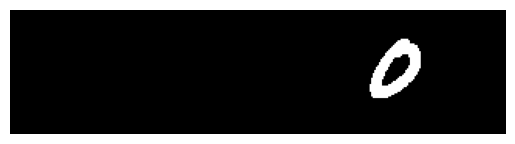

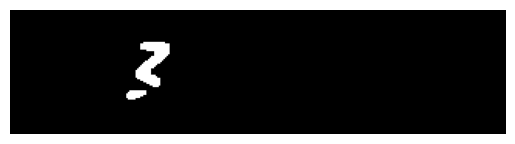

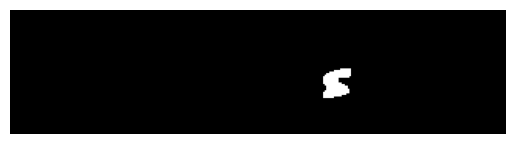

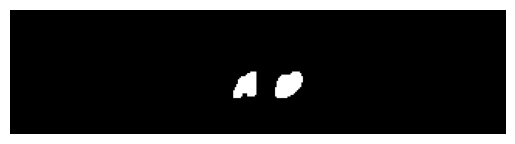

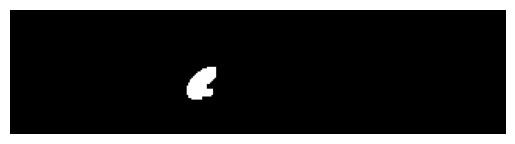

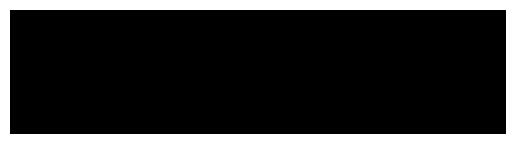

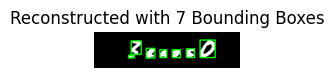

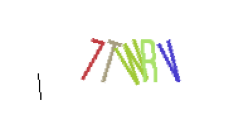

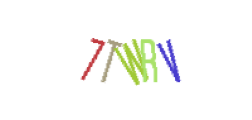

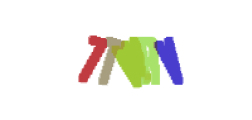

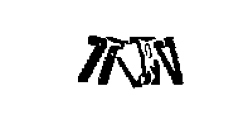

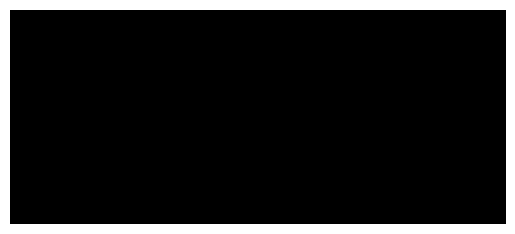

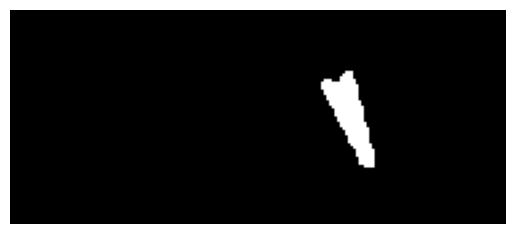

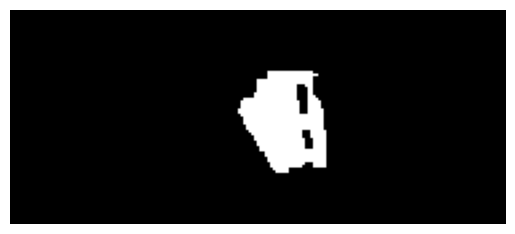

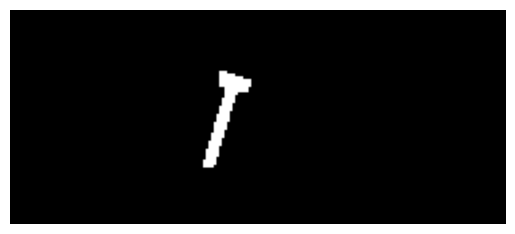

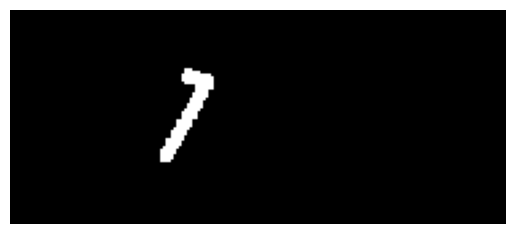

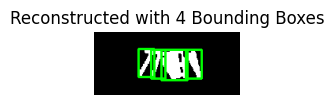

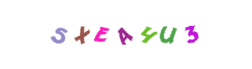

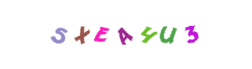

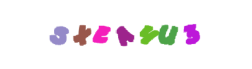

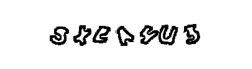

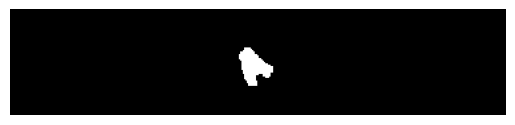

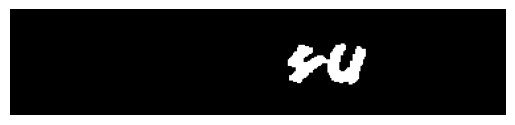

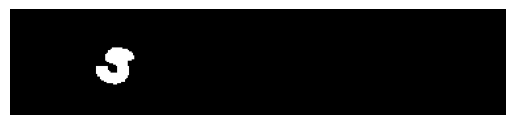

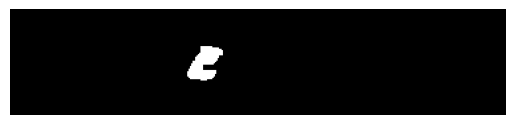

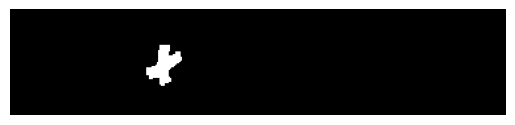

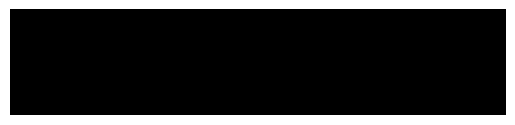

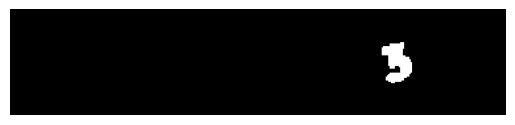

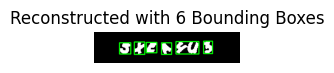

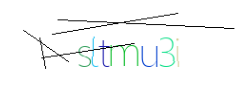

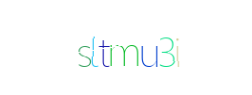

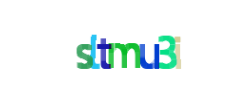

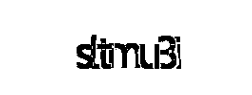

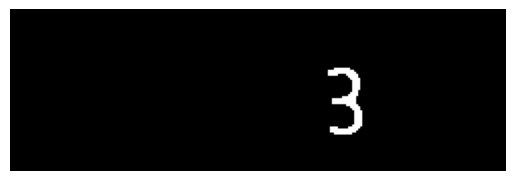

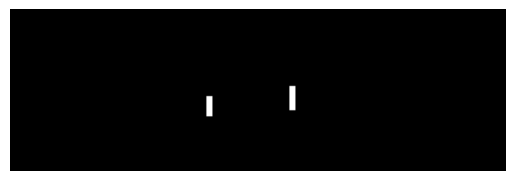

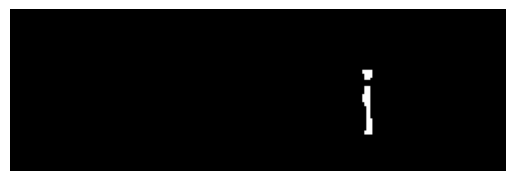

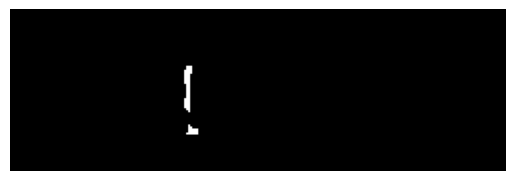

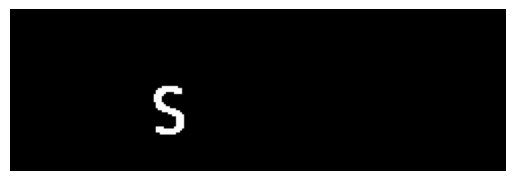

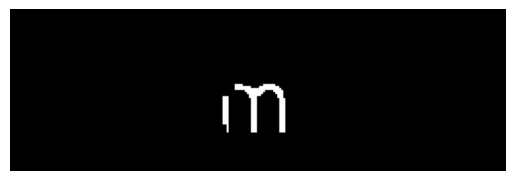

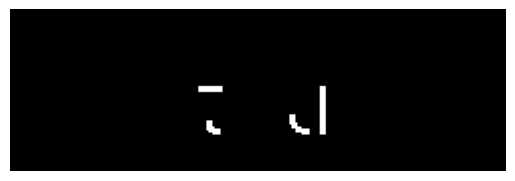

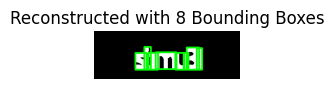

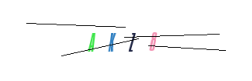

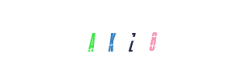

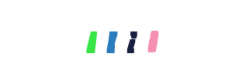

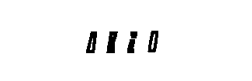

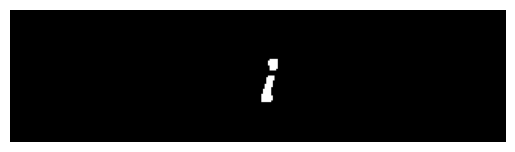

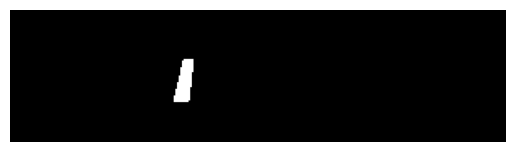

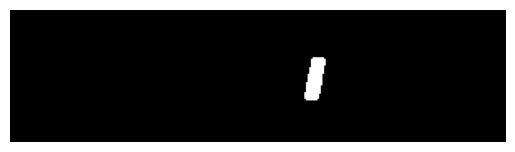

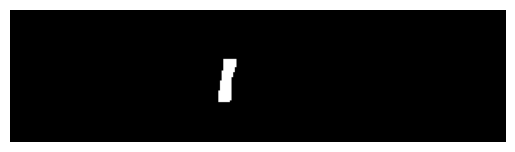

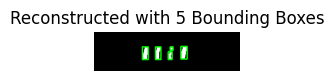

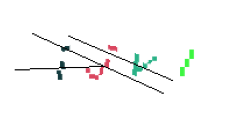

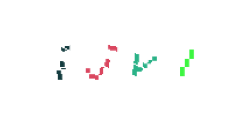

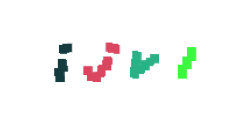

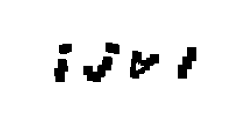

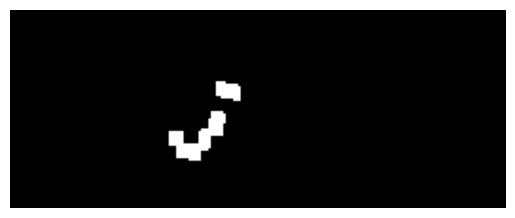

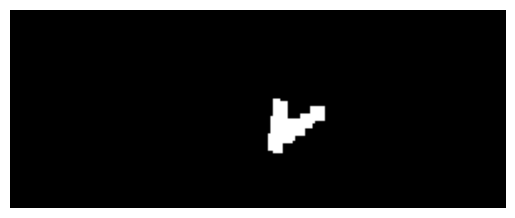

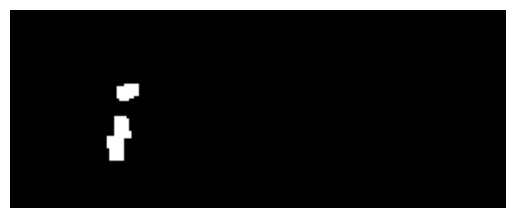

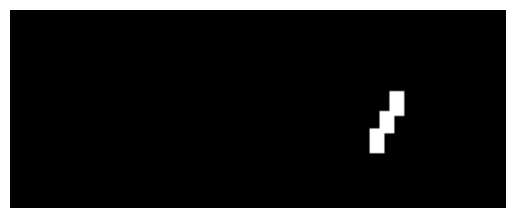

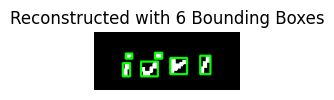

Mismatch count: 20
Smaller count: 8
Larger count: 12


In [ ]:
from tqdm import tqdm

def run(mode: int):
    folder_path = 'data/train'
    filenames = os.listdir(folder_path)

    mismatch_count = 0
    smaller_count = 0
    larger_count = 0

    if mode == 1:
        mismatch_filenames = []
        for filename in tqdm(filenames, desc="Processing images"):
            try:
                image_path = os.path.join(folder_path, filename)
                match = process_image(image_path)
                if match != 'correct':
                    mismatch_count += 1
                    if match == 'smaller':
                        smaller_count += 1
                    else:
                        larger_count += 1
                    mismatch_filenames.append(filename)
            except Exception as e:
                mismatch_filenames.append(f"Error: {filename}")
                print(f"Error processing {filename}: {e}")

        print(f"Mismatch count: {mismatch_count}")
        print(f"Smaller count: {smaller_count}")
        print(f"Larger count: {larger_count}")

        # Save mismatch filenames to a text file
        with open("mismatches_3.txt", "w") as f:
            for name in mismatch_filenames:
                f.write(name + "\n")

    elif mode == 2:
        # Read image filenames from mismatches.txt and process them
        with open("mismatches_3.txt", "r") as f:
            image_paths = [line.strip() for line in f if line.strip()]
            total_files = len(image_paths)
        for image_path in image_paths[:20]:
            match = process_image(os.path.join('data/train', image_path), show_images=True)
            if match != 'correct':
                mismatch_count += 1
                if match == 'smaller':
                    smaller_count += 1
                else:
                    larger_count += 1

        print(f"Mismatch count: {mismatch_count}")
        print(f"Smaller count: {smaller_count}")
        print(f"Larger count: {larger_count}")

run(2)

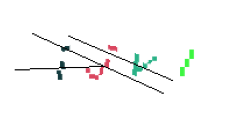

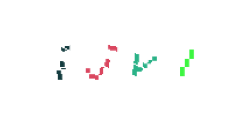

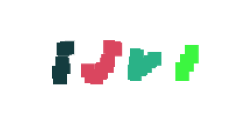

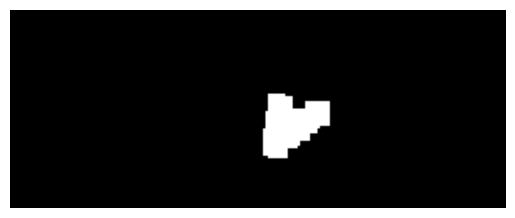

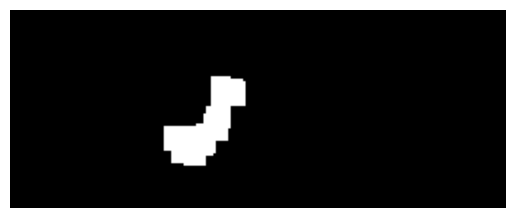

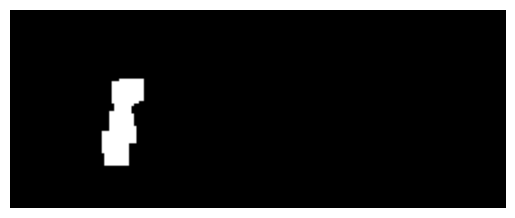

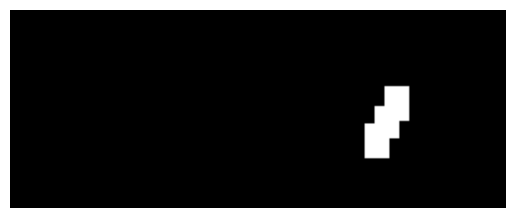

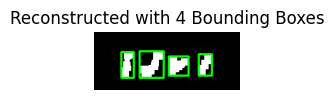

'correct'

In [577]:
filename = "ijv1-0.png"
image_path = os.path.join('data/train', filename)
process_image(image_path, show_images=True)